### Neural Networks to fit $y = \sin(\theta)$ and $\theta = \arcsin(y)$

In [1]:
# Library imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

# Aliases
keras = tf.keras

In [2]:
# Local imports
from utils import gpu_grow_memory, TimeHistory, EpochLoss, plot_loss_hist
from utils import load_vartbl, save_vartbl, plot_style

from polar_coord import make_data_sin, make_dataset_sin
from polar_coord import make_model_sin_math, make_model_pow
from polar_coord import compile_and_fit, make_model_autoencoder

In [3]:
# Grow GPU memory (must be first operation in TF)
gpu_grow_memory()

In [4]:
# Plot style 
plot_style()

In [5]:
# Lightweight serialization
fname = '../pickle/polar_coord.pickle'
vartbl = load_vartbl(fname)

## Create datasets for $\theta \in [-\pi/2, \pi/2]$ and $y \in [-1, 1]$

In [6]:
# Make datasets for sin
n = 36000
data_sin = make_data_sin(n)
ds_p2c, ds_c2p, ds_p2p, ds_c2c = make_dataset_sin(n=n, batch_size=3600)

In [7]:
# Set number of epochs
epoch_size = n+1
epochs = (20000 * 3600) // n
samples_total = epochs * epoch_size

# Set save_freq in terms of SAMPLES
save_freq = samples_total // 10

# Print summary
print(f'Built data set with n={n:,}.')
print(f'Training for {epochs} epochs total, with {samples_total:,} sample points total.')
print(f'Save frequency every {save_freq:,} samples.')

Built data set with n=36,000.
Training for 2000 epochs total, with 72,002,000 sample points total.
Save frequency every 7,200,200 samples.


In [8]:
# Unpack one example batch
# theta, y = list(ds_p2c.take(1))[0]
# theta, y = theta.numpy(), y.numpy()

# Review data contents
# print(f'theta: min={np.min(theta):+8.5}, max={np.max(theta):+8.5}')
# print(f'    y: min={np.min(y):+8.5}, max={np.max(y):+8.5}')

In [9]:
theta = data_sin['theta']
y = data_sin['y']

## Deterministic Mathematical Models

In [10]:
# Mathematical models
math_p2c, math_c2p, math_p2p, math_c2c = make_model_sin_math()

In [11]:
# Set loss function and optimizer
loss = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam()
metrics = [keras.metrics.MeanAbsoluteError()]

# Set save_freq in terms of SAMPLES; this is every 500 epochs
epoch_size = n+1
save_freq = 500 * epoch_size

In [12]:
# Compile the math models
math_p2c.compile(loss=loss, optimizer=optimizer, metrics=metrics)
math_c2p.compile(loss=loss, optimizer=optimizer, metrics=metrics)
math_p2p.compile(loss=loss, optimizer=optimizer, metrics=metrics)
math_c2c.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [13]:
# Evaluate the p2c math model
# math_p2c.evaluate(theta, y)
math_p2c.evaluate(ds_p2c)

11/11 [==============================] - 0s 19ms/step - loss: 2.7116e-16 - mean_absolute_error: 5.2202e-09


[2.7115795508065617e-16, 5.2202282e-09]

In [14]:
# Evaluate the c2p math model
# math_p2c.evaluate(y, theta)
math_c2p.evaluate(ds_c2p)

11/11 [==============================] - 0s 17ms/step - loss: 6.1598e-12 - mean_absolute_error: 1.1968e-07


[6.159803837348304e-12, 1.1967545e-07]

In [16]:
# Evaluate the p2p math model
# math_p2p.evaluate(theta, theta)
math_p2p.evaluate(ds_p2p)

11/11 [==============================] - 0s 13ms/step - loss: 2.7412e-12 - mean_absolute_error: 1.0840e-07


[2.741160762213907e-12, 1.08398076e-07]

In [17]:
# Evaluate the c2c math model
# math_c2c.evaluate(x, x)
math_c2c.evaluate(ds_c2c)

11/11 [==============================] - 0s 16ms/step - loss: 6.3275e-16 - mean_absolute_error: 1.2302e-08


[6.327452968034847e-16, 1.2302326e-08]

## Functions for visualizing neural network outputs $y = \sin(\theta)$

In [18]:
def plot_pred_sin(model, theta):
    # Predictions of the model
    y_pred = model.predict(theta)
    y_pred = y_pred.reshape((-1,))
    
    # Plot predictions
    fig, ax = plt.subplots(figsize=[16,9])
    ax.set_title(f'$y = \sin(\\theta)$ in {model.name}')
    ax.set_xlabel('$\\theta$')
    ax.set_ylabel('$y$')
    ax.set_xlim(-np.pi/2.0, np.pi/2.0)
    ax.set_xticks(np.linspace(-np.pi/2.0, np.pi/2.0, 5))
    ax.set_xticklabels(['$-\pi/2$', '$-\pi/4$', '0', '$\pi/4$', '$\pi/2$'])
    ax.set_ylim(-1.05, 1.05)
    ax.set_yticks(np.linspace(-1.0, 1.0, 9))
    ax.plot(theta, y, color='blue', label='$\sin(\\theta)$', linewidth=4.0)
    ax.plot(theta, y_pred, color='red', label='NN$(\\theta)$', linewidth=2.0)
    ax.grid()
    ax.legend()
    return fig, ax

In [19]:
def plot_error_sin(model, theta):
    # Predictions of the model
    y_pred = model.predict(theta)
    y_pred = y_pred.reshape((-1,))
    error = y_pred - np.sin(theta)
    
    # Plot errors
    fig, ax = plt.subplots(figsize=[16,9])
    ax.set_title(f'Error for $y = \sin(\\theta)$ in {model.name}')
    ax.set_xlabel('$\\theta$')
    ax.set_ylabel('error = $\sin(\\theta)$ - NN($\\theta$)')
    ax.set_xlim(-np.pi/2.0, np.pi/2.0)
    ax.set_xticks(np.linspace(-np.pi/2.0, np.pi/2.0, 5))
    ax.set_xticklabels(['$-\pi/2$', '$-\pi/4$', '0', '$\pi/4$', '$\pi/2$'])
    ax.plot(theta, error, color='red', label='error', linewidth=4.0)
    ax.grid()
    # ax.legend()
    return fig, ax

## Neural networks for $y = \sin(\theta)$

### Network Design 1: [64]
(model_sin_64 has one layer with 64 hidden units)

In [21]:
# Build the NN model of y=sin(theta)
model_sin_64 = make_model_pow(func_name='sin', 
                              input_name='theta',
                              output_name='y',
                              powers=[1,3,5,7],
                              skip_layers=True,
                              hidden_sizes=[64])

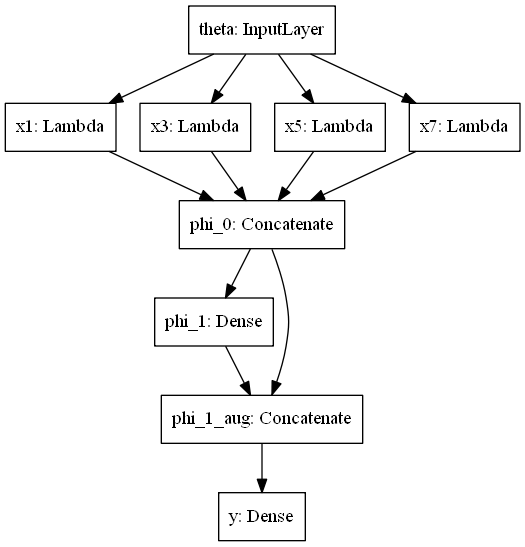

In [22]:
keras.utils.plot_model(model_sin_64)

In [23]:
model_sin_64.summary()

Model: "model_sin_[64]"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
theta (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
x1 (Lambda)                     (None, 1)            0           theta[0][0]                      
__________________________________________________________________________________________________
x3 (Lambda)                     (None, 1)            0           theta[0][0]                      
__________________________________________________________________________________________________
x5 (Lambda)                     (None, 1)            0           theta[0][0]                      
_____________________________________________________________________________________

**Load the network and its loss history if available; otherwise train it**

In [24]:
loss=keras.losses.MeanSquaredError()

optimizer=keras.optimizers.Adam(learning_rate=1.0E-3)
# optimizer=keras.optimizers.Adadelta(learning_rate=1.0E-1)
# optimizer=keras.optimizers.SGD(learning_rate=1.0E-3, momentum=0.5)

try:
    model_sin_64.load_weights('../models/polar/model_sin_[64].h5')
    model_sin_64.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    hist_sin_64 = vartbl['hist_sin_64']
    print('Loaded model_sin_64.')
except:
    hist = compile_and_fit(model=model_sin_64, 
                           ds=ds_p2c, 
                           epochs=epochs,
                           loss=loss, 
                           optimizer=optimizer,
                           metrics=metrics,
                           save_freq=save_freq)
    hist_sin_64 = hist.history
    vartbl['hist_sin_64'] = hist_sin_64
    save_vartbl(vartbl, fname)

Epoch 0001; loss 3.53e-01; elapsed 0:00:01
Epoch 0100; loss 1.72e-05; elapsed 0:00:13
Epoch 0200; loss 1.07e-05; elapsed 0:00:26
Epoch 0300; loss 4.61e-06; elapsed 0:00:38
Epoch 0400; loss 9.34e-07; elapsed 0:00:50
Epoch 0500; loss 6.36e-08; elapsed 0:01:02
Epoch 0600; loss 1.28e-08; elapsed 0:01:14
Epoch 0700; loss 1.30e-08; elapsed 0:01:26
Restoring model weights from the end of the best epoch.
Epoch 00771: early stopping


In [25]:
model_sin_64.evaluate(ds_p2c)

11/11 [==============================] - 0s 20ms/step - loss: 5.6410e-08 - mean_absolute_error: 2.2377e-04


[5.641012344106209e-08, 0.00022376628]

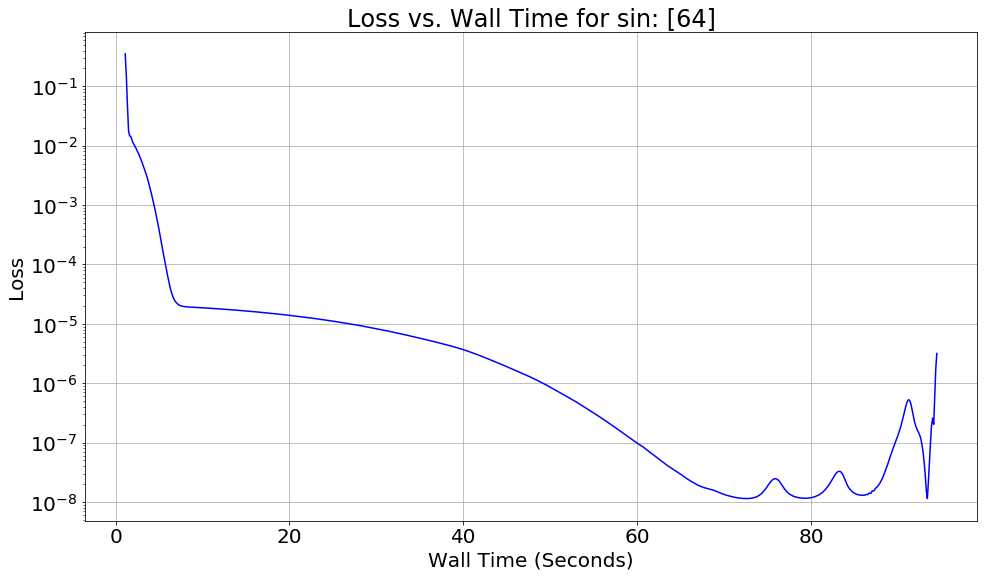

In [26]:
fig, ax = plot_loss_hist(hist_sin_64, 'sin: [64]')

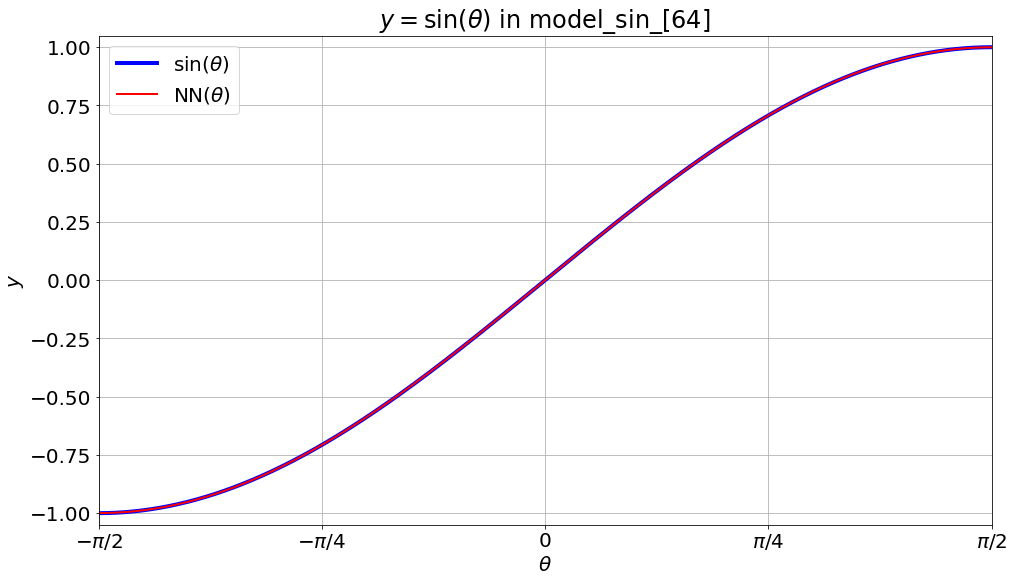

In [27]:
fig, ax = plot_pred_sin(model_sin_64, theta)

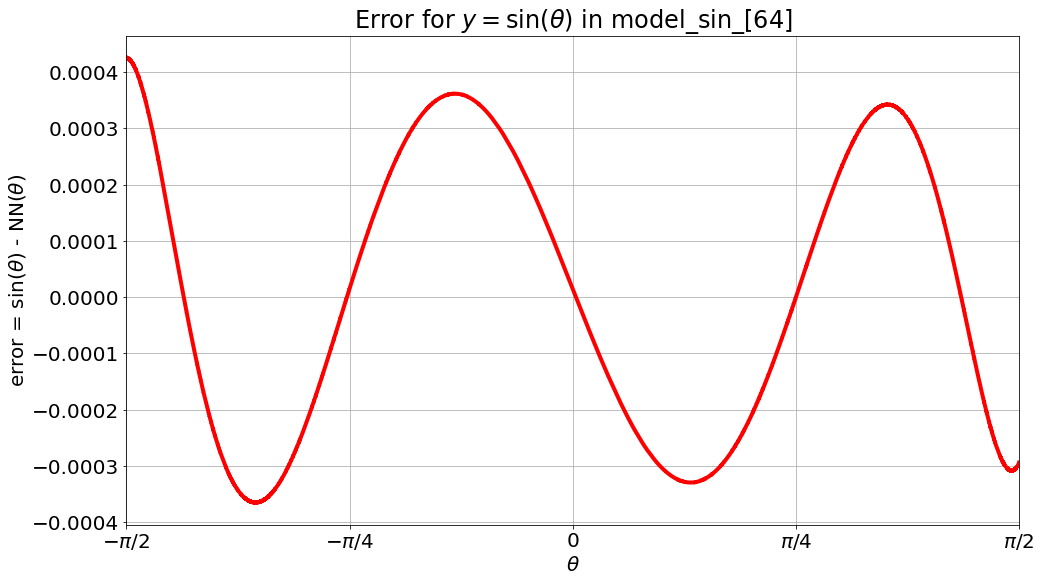

In [28]:
fig, ax = plot_error_sin(model_sin_64, theta)

### Network Design 2: [16, 16]
(model_sin_16_16 has two layers with 16 hidden units each)

In [30]:
model_sin_16_16 = make_model_pow(func_name='sin', 
                                 input_name='theta',
                                 output_name='y',
                                 powers=[1,3,5,7],
                                 skip_layers=True,
                                 hidden_sizes=[16, 16])

In [31]:
model_sin_16_16.summary()

Model: "model_sin_[16, 16]"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
theta (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
x1 (Lambda)                     (None, 1)            0           theta[0][0]                      
__________________________________________________________________________________________________
x3 (Lambda)                     (None, 1)            0           theta[0][0]                      
__________________________________________________________________________________________________
x5 (Lambda)                     (None, 1)            0           theta[0][0]                      
_________________________________________________________________________________

**Load the network and its loss history if available; otherwise train it**

In [32]:
loss=keras.losses.MeanSquaredError()
optimizer=keras.optimizers.Adam(learning_rate=1.0E-3)

try:
    model_sin_16_16.load_weights('../models/polar/model_sin_[16, 16].h5')
    model_sin_16_16.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    hist_sin_16_16 = vartbl['hist_sin_16_16']
    print('Loaded model_sin_16_16.')
except:
    hist = compile_and_fit(model=model_sin_16_16, 
                           ds=ds_p2c, 
                           epochs=epochs,
                           loss=loss, 
                           optimizer=optimizer,
                           metrics=metrics,
                           save_freq=save_freq)
    hist_sin_16_16 = hist.history
    vartbl['hist_sin_16_16'] = hist_sin_16_16
    save_vartbl(vartbl, fname)

Epoch 0001; loss 6.29e-01; elapsed 0:00:01
Epoch 0100; loss 1.55e-05; elapsed 0:00:13
Epoch 0200; loss 4.11e-06; elapsed 0:00:26
Epoch 0300; loss 4.26e-07; elapsed 0:00:39
Epoch 0400; loss 7.84e-08; elapsed 0:00:51
Epoch 0500; loss 7.71e-08; elapsed 0:01:03
Epoch 0600; loss 6.25e-08; elapsed 0:01:16
Epoch 0700; loss 1.05e-07; elapsed 0:01:28
Restoring model weights from the end of the best epoch.
Epoch 00760: early stopping


In [33]:
model_sin_16_16.evaluate(ds_p2c)

11/11 [==============================] - 0s 21ms/step - loss: 8.7964e-08 - mean_absolute_error: 2.5498e-04


[8.796409709723528e-08, 0.0002549775]

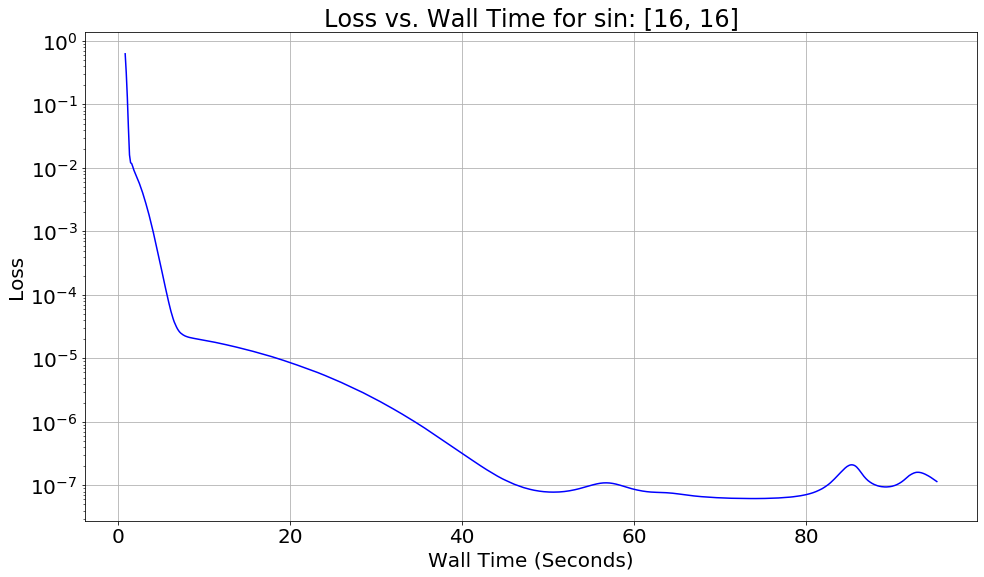

In [34]:
fig, ax = plot_loss_hist(hist_sin_16_16, 'sin: [16, 16]')

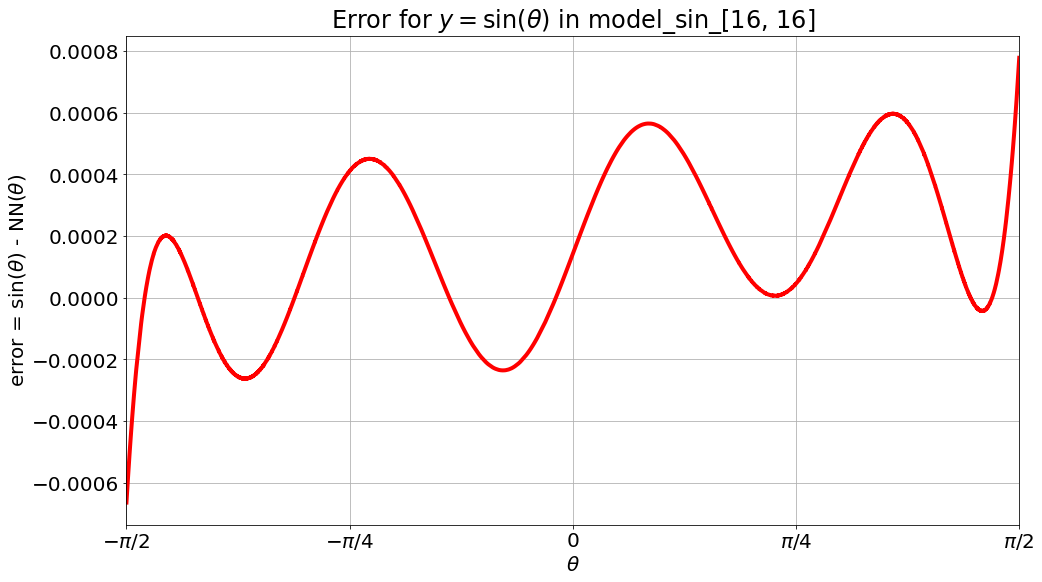

In [35]:
fig, ax = plot_error_sin(model_sin_16_16, theta)

## Neural networks for $\theta = \arcsin(y)$

## Functions for visualizing neural network outputs $\theta = \arcsin(y)$

In [36]:
def plot_pred_arcsin(model, y):
    # Predictions of the model
    theta_pred = model.predict(y)
    theta_pred = theta_pred.reshape((-1,))
    
    # Plot predictions
    fig, ax = plt.subplots(figsize=[16,9])
    ax.set_title(f'$\\theta = \\arcsin(y)$ for {model.name}')
    ax.set_xlabel('$y$')
    ax.set_ylabel('$\\theta$')
    ax.set_xlim(-1.05, 1.05)
    ax.set_xticks(np.linspace(-1.0, 1.0, 9))
    ax.set_ylim(-np.pi/2.0, np.pi/2.0)
    ax.set_yticks(np.linspace(-np.pi/2.0, np.pi/2.0, 5))
    ax.set_yticklabels(['$-\pi/2$', '$-\pi/4$', '0', '$\pi/4$', '$\pi/2$'])
    ax.plot(y, theta, color='blue', label='$\\arcsin(y)$', linewidth=4.0)
    ax.plot(y, theta_pred, color='red', label='NN$(y)$', linewidth=2.0)
    ax.grid()
    ax.legend()
    return fig, ax

In [37]:
def plot_error_arcsin(model, y):
    # Predictions of the model
    theta_pred = model.predict(y)
    theta_pred = theta_pred.reshape((-1,))
    error = theta - theta_pred
    
    # Plot predictions
    fig, ax = plt.subplots(figsize=[16,9])
    ax.set_title(f'Error in $\\theta = \\arcsin(y)$ for {model.name}')
    ax.set_xlabel('$y$')
    ax.set_ylabel('$\\theta$')
    ax.set_xlim(-1.05, 1.05)
    ax.set_xticks(np.linspace(-1.0, 1.0, 9))
    ax.plot(y, error, color='red', label='error', linewidth=4.0)
    ax.grid()
    ax.legend()
    return fig, ax

### Network Design 1: [64]

In [39]:
model_arcsin_64 = make_model_pow(func_name='arcsin', 
                                 input_name = 'y',
                                 output_name='theta',
                                 powers=[1,3,5,7],
                                 skip_layers=True,
                                 hidden_sizes=[64])

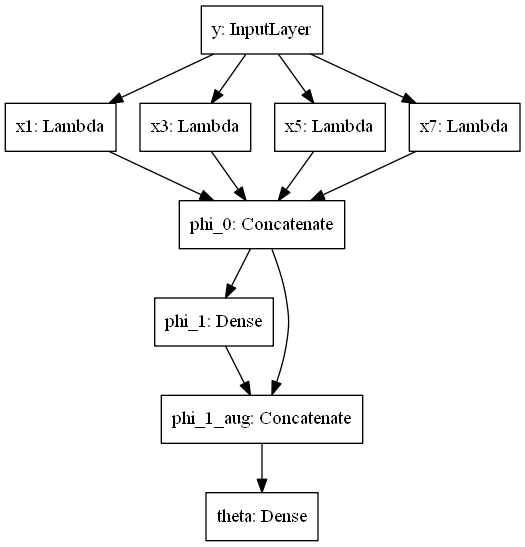

In [40]:
keras.utils.plot_model(model_arcsin_64)

In [41]:
model_arcsin_64.summary()

Model: "model_arcsin_[64]"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
y (InputLayer)                  [(None, 1)]          0                                            
__________________________________________________________________________________________________
x1 (Lambda)                     (None, 1)            0           y[0][0]                          
__________________________________________________________________________________________________
x3 (Lambda)                     (None, 1)            0           y[0][0]                          
__________________________________________________________________________________________________
x5 (Lambda)                     (None, 1)            0           y[0][0]                          
__________________________________________________________________________________

In [42]:
loss=keras.losses.MeanSquaredError()
optimizer=keras.optimizers.Adam(learning_rate=1.0E-3)

try:
    model_arcsin_64.load_weights('../models/polar/model_arcsin_[64].h5')
    model_arcsin_64.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    hist_arcsin_64 = vartbl['hist_arcsin_64']
    print('Loaded model_arcsin_64.')
except:
    hist = compile_and_fit(model=model_arcsin_64, 
                           ds=ds_c2p, 
                           epochs=epochs,
                           loss=loss, 
                           optimizer=optimizer,
                           metrics=metrics,
                           save_freq=save_freq)
    hist_arcsin_64 = hist.history
    vartbl['hist_arcsin_64'] = hist_arcsin_64
    save_vartbl(vartbl, fname)

Epoch 0001; loss 1.14e-01; elapsed 0:00:01
Epoch 0100; loss 1.87e-03; elapsed 0:00:12
Epoch 0200; loss 1.82e-03; elapsed 0:00:24
Epoch 0300; loss 1.74e-03; elapsed 0:00:36
Epoch 0400; loss 1.64e-03; elapsed 0:00:48
Epoch 0500; loss 1.51e-03; elapsed 0:00:59
Epoch 0600; loss 1.38e-03; elapsed 0:01:11
Epoch 0700; loss 1.22e-03; elapsed 0:01:23
Epoch 0800; loss 1.07e-03; elapsed 0:01:35
Epoch 0900; loss 9.32e-04; elapsed 0:01:46
Epoch 1000; loss 8.09e-04; elapsed 0:01:58
Epoch 1100; loss 6.52e-04; elapsed 0:02:10
Epoch 1200; loss 6.23e-04; elapsed 0:02:22
Epoch 1300; loss 6.14e-04; elapsed 0:02:34
Epoch 1400; loss 6.11e-04; elapsed 0:02:46
Epoch 1500; loss 6.10e-04; elapsed 0:02:57
Epoch 1600; loss 6.10e-04; elapsed 0:03:09
Epoch 1700; loss 6.09e-04; elapsed 0:03:21
Epoch 1800; loss 6.09e-04; elapsed 0:03:33
Epoch 1900; loss 6.09e-04; elapsed 0:03:44
Epoch 2000; loss 6.08e-04; elapsed 0:03:56


In [43]:
model_arcsin_64.evaluate(ds_c2p)

11/11 [==============================] - 0s 19ms/step - loss: 5.6639e-04 - mean_absolute_error: 0.0186


[0.0005663916757198835, 0.018638212]

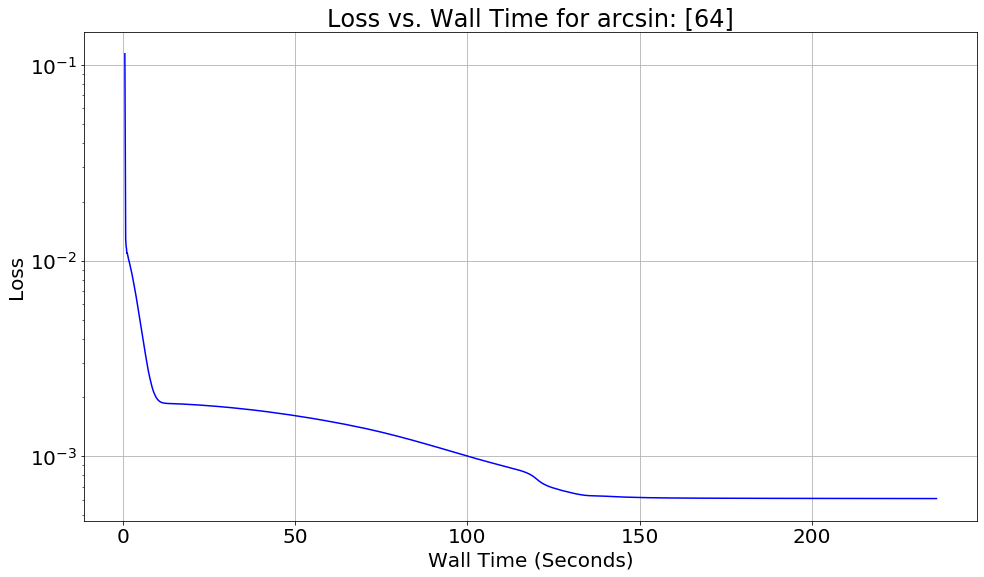

In [44]:
fig, ax = plot_loss_hist(hist_arcsin_64, 'arcsin: [64]')

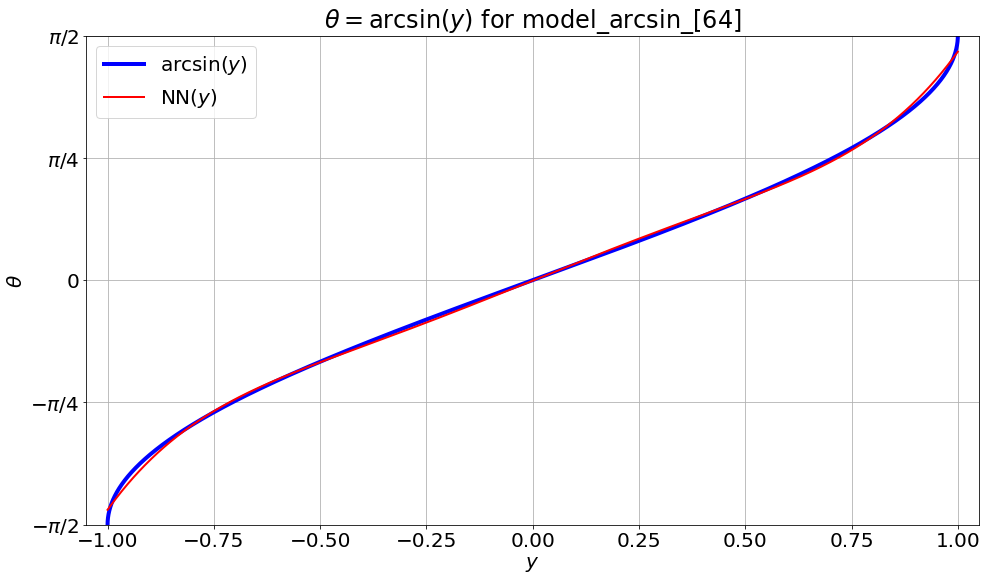

In [45]:
fig, ax = plot_pred_arcsin(model_arcsin_64, y)

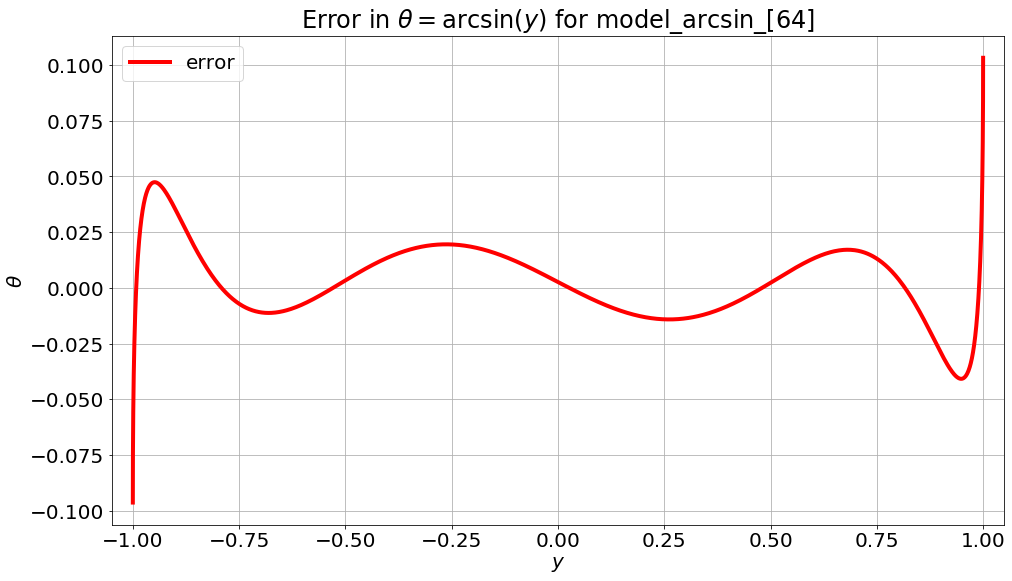

In [46]:
fig, ax = plot_error_arcsin(model_arcsin_64, y)

### Network Design 2: [16, 16]

In [ ]:
model_arcsin_16_16 = make_model_pow(func_name='arcsin', 
                                    input_name = 'y',
                                    output_name='theta',
                                    powers=[1,3,5,7],
                                    skip_layers=True,
                                    hidden_sizes=[16, 16])

In [ ]:
keras.utils.plot_model(model_arcsin_16_16)

In [ ]:
model_arcsin_16_16.summary()

In [ ]:
loss=keras.losses.MeanSquaredError()
optimizer=keras.optimizers.Adam(learning_rate=1.0E-3)

try:
    model_arcsin_16_16.load_weights('../models/polar/model_arcsin_[16, 16].h5')
    model_arcsin_16_16.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    hist_arcsin_16_16 = vartbl['hist_arcsin_16_16']
    print('Loaded model_arcsin_16_16.')
except:
    hist = compile_and_fit(model=model_arcsin_16_16, 
                           ds=ds_c2p, 
                           epochs=epochs,
                           loss=loss, 
                           optimizer=optimizer,
                           metrics=metrics,
                           save_freq=save_freq)
    hist_arcsin_16_16 = hist.history
    vartbl['hist_arcsin_16_16'] = hist_arcsin_16_16
    save_vartbl(vartbl, fname)

In [ ]:
model_arcsin_16_16.evaluate(ds_c2p)

In [ ]:
fig, ax = plot_loss_hist(hist_arcsin_16_16, 'arcsin: [16, 16]')

In [ ]:
fig, ax = plot_pred_arcsin(model_arcsin_16_16, y)

In [ ]:
fig, ax = plot_error_arcsin(model_arcsin_16_16, y)

In [ ]:
# copies of model instances
model_sin = keras.models.clone_model(model_sin_16_16)
model_sin.set_weights(model_sin_16_16.get_weights())
model_arcsin = keras.models.clone_model(model_arcsin_16_16)
model_arcsin.set_weights(model_arcsin_16_16.get_weights())

# remove special characters from model names
# otherwise make_model_autoencoder fails with invalid scope name due to [16, 16] in model names
model_sin._name = 'model_sin'
model_arcsin._name = 'model_arcsin'

In [ ]:
model_p2p, model_c2c = make_model_autoencoder(
    model_p2c = model_sin,
    model_c2p = model_arcsin)

In [ ]:
model_p2p.compile(loss=loss, optimizer=optimizer, metrics=metrics)
model_p2p.evaluate(ds_p2p)

In [ ]:
model_c2c.compile(loss=loss, optimizer=optimizer, metrics=metrics)
model_c2c.evaluate(ds_c2c)